# Parte 3: Introdução à Modelagem Penalizada — Ridge e LASSO
 
Nesta parte do trabalho, desenvolvemos os modelos penalizados que servem como alternativa ao OLS tradicional, permitindo lidar com a alta dimensionalidade e a multicolinearidade presentes no dataset (228 variáveis). Contudo, utilizamos os dados pré-processados de etapas anteriores, tendo eles apenas 192 variáveis.  
Nosso foco é implementar, avaliar e comparar modelos Ridge ou LASSO tanto na versão **feita do zero** quanto na **versão do scikit-learn**, analisando como cada abordagem controla a magnitude dos coeficientes e melhora a capacidade de generalização.

Utilizaremos as funções fornecidas no arquivo `funcoes_base.py`, responsáveis por:

- `rmse`: cálculo da raiz do erro quadrático médio;
- `r2`: cálculo do coeficiente de determinação;
- `cross_validate`: avaliação do modelo via validação cruzada k-fold.
- `evaluate_lambda_grid`: recebe um modelo, um grid de lambdas e avalia o RMSE e R2 para cada lambda

Também serão utilizadas as funções do arquivo `Ridge.py`, responsáveis por:

- `ridge_train_beta`: treina um modelo Ridge utilizando a formulação matricial para calcular os coeficientes regularizados (β) e o intercepto;  
- `ridge_predict`: realiza previsões com base nos coeficientes e intercepto treinados;  
- `ridge_factory`: retorna uma função de predição parametrizada por um λ específico, pronta para uso na validação cruzada;  
- `best_ridge_lambda`: variável ou função que armazena/retorna o λ que minimiza o RMSE via validação cruzada.

E, por fim, as funções do arquivo `LASSO.py`, responsáveis por:

- `lasso_cd_train`: treina um modelo LASSO usando o método de coordinate descent, retornando coeficientes e intercepto;  
- `lasso_predict`: realiza previsões com base nos coeficientes e intercepto treinados;  
- `lasso_factory`: retorna uma função de predição parametrizada por um λ específico, pronta para uso na validação cruzada;  
- `best_lasso_lambda`: variável ou função que armazena/retorna o λ que minimiza o RMSE via validação cruzada.


Essas funções estruturam toda a análise de desempenho dos modelos penalizados e permitem comparar diretamente a implementação manual com a implementação da biblioteca.



## 1. Importações e Configuração do Ambiente

Nesta etapa inicial, carregamos todas as bibliotecas necessárias para o desenvolvimento do modelo penalizado.  
Também realizamos a configuração do caminho (`sys.path`) para garantir que o notebook consiga localizar corretamente o diretório `src/`, onde se encontra os arquivos `funcoes_base.py`, `LASSO.py`, `Ridge.py`, independente do computador em que esteja sendo executado.

In [ ]:
# 1) Imports e configuração de caminho para achar "src/"
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge as SkRidge
from sklearn.linear_model import Lasso as SkLasso

# --- Ajuste importante ---
# Caminho para a pasta raiz do projeto (um nível acima de /notebooks/)
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_PATH = os.path.join(ROOT, "src")

# Adiciona ao sys.path caso não esteja lá
if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)

print("Diretório raiz detectado:", ROOT)
print("src/ adicionado ao sys.path:", SRC_PATH)

# Agora podemos importar as funções base normalmente:
try:
    from funcoes_base import rmse, r2, cross_validate, evaluate_lambda_grid
    print("Funções Base importadas com sucesso!")
except Exception as e:
    print("Não consegui importar from src/funcoes_base.py.")
try:
    from Ridge import ridge_train_beta, ridge_predict, ridge_factory, Best_ridge_lambda
    print("Ridge importado com sucesso!")
except Exception as e:
    print("Não consegui importar from src/Ridge.py.")
try:
    from LASSO import lasso_cd_train, lasso_predict, lasso_factory, Best_lasso_lambda
    print("Lasso importado com sucesso!")
except Exception as e:
    print("Não consegui importar from src/Lasso.py.")

Diretório raiz detectado: c:\Users\User\Desktop\UFC\TI0175 - INTELIGÊNCIA COMPUTACIONAL APLICADA\HomeWork_02\Códigos\HW2-ICA-2025.2
src/ adicionado ao sys.path: c:\Users\User\Desktop\UFC\TI0175 - INTELIGÊNCIA COMPUTACIONAL APLICADA\HomeWork_02\Códigos\HW2-ICA-2025.2\src
Funções Base importadas com sucesso!
Ridge importado com sucesso!
Lasso importado com sucesso!


## 2. Carregamento dos Dados Pré-processados

Nesta etapa realizamos o carregamento do conjunto de dados pré-processado anteriormente.  
O arquivo `dados_preprocessados.pkl` contém uma tupla com:

1. X_train_processed  
2. X_test_processed  
3. y_train  
4. y_test  

Esses dados já passaram por normalização e correções necessárias, permitindo que a modelagem penalizada seja aplicada diretamente.

Durante o carregamento, garantimos que eventuais DataFrames sejam convertidos para arrays NumPy, assegurando compatibilidade com os cálculos matriciais dos métodos Ridge e LASSO implementados posteriormente.

Ao final, exibimos os formatos das matrizes e vetores carregados para confirmar que tudo está consistente.


In [17]:
# 2) Carregamento dos dados pré-processados
import pickle
import numpy as np

def load_preprocessed(pkl_path="dados_preprocessados.pkl"):
    with open(pkl_path, "rb") as f:
        obj = pickle.load(f)

    # Esperado: tupla (X_train, X_test, y_train, y_test)
    X_train, X_test, y_train, y_test = obj

    # Converte DataFrame -> numpy caso seja necessário
    if hasattr(X_train, "values"): X_train = X_train.values
    if hasattr(X_test,  "values"): X_test  = X_test.values

    return X_train, X_test, y_train, y_test

# Carregar os dados
X_train, X_test, y_train, y_test = load_preprocessed()

# Exibir shapes
print("Shapes carregados:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)


Shapes carregados:
X_train: (951, 192)
X_test : (316, 192)
y_train: (951,)
y_test : (316,)


## 3) Regressão Ridge: implementação pela solução fechada

Nesta seção implementamos o modelo de **Ridge Regression** utilizando a solução fechada.  
O objetivo é resolver o problema

$$\|y - X\beta\|^2 + \lambda\|\beta\|^2$$


que adiciona uma penalização quadrática sobre os coeficientes para controlar overfitting.

A estratégia adotada é:

- Centralizar o vetor y, removendo sua média.
- Resolver o sistema linear: 
  $$(X^\top X + \lambda I)\beta = X^\top (y - \bar{y})$$
  usando `numpy.linalg.solve`, evitando a inversão explícita de matriz.
- Recuperar o intercepto como a média original de y.
- Definir a função preditora como $$\hat{y} = X\beta + \text{intercept}$$

Ao final, incluímos um pequeno teste rápido apenas para verificar se a forma dos coeficientes está correta.


In [18]:
# Retorna (beta, intercept). Implementação assume que X NÃO tem coluna de 1s.
    # Estratégia: centrar y, resolver para beta que minimiza ||y_center - X beta||^2 + lambda ||beta||^2.
    # Intercepto retornado é a média de y ( adicionada de volta nas previsões ).
# Teste rápido (sanity)
_beta, _int = ridge_train_beta(X_train[:10,:], y_train[:10], lambda_value=1.0)
print('Teste Ridge (sanity): beta.shape =', _beta.shape)

Teste Ridge (sanity): beta.shape = (192,)


## 4) Implementação do LASSO usando Coordinate Descent

Nesta seção implementamos o modelo **LASSO** a partir do zero utilizando o método **Coordinate Descent (CD)**.  
Diferentemente do Ridge, o LASSO não possui solução fechada; sua solução emerge da aplicação do operador de *soft-thresholding* em cada coordenada do vetor de coeficientes.

O LASSO resolve o problema de otimização:

$$\min_{\beta} \; \|y - X\beta\|^2 + \lambda \|\beta\|_1$$

O termo L1 promove esparsidade, permitindo que coeficientes sejam exatamente zerados.

### Soft-thresholding

A atualização de cada coordenada usa o operador:


$$S(\rho, \lambda) = 

\begin{cases}
\rho - \lambda, & \rho > \lambda \\
0, & |\rho| \le \lambda \\
\rho + \lambda, & \rho < -\lambda
\end{cases}$$


Esse operador é o responsável direto por "cortar" coeficientes pequenos, produzindo sparsity.

### Estratégia da implementação

A implementação segue estes passos:

1. Centralizar $y$ para que o intercepto seja tratado separadamente.  
2. Centralizar e normalizar cada coluna de $X$, o que estabiliza o Coordinate Descent.  
3. Atualizar cada coeficiente $\beta_j$ isoladamente aplicando o soft-thresholding:  

$$\beta_j = \frac{S(\rho_j, \lambda/2)}{\sum_i X_{ij}^2}$$

4. Verificar convergência comparando o máximo deslocamento entre iterações:  

$$\max_j |\beta^{(t)}_j - \beta^{(t-1)}_j|$$

5. Ao final, reescalar os coeficientes para a escala original dos atributos.  
6. Recalcular o intercepto:  

$$\text{intercept} = \bar{y} - \bar{X}^\top \beta$$

Esta abordagem é exata, clara e compatível com implementações clássicas de LASSO via Coordinate Descent.



In [19]:
# 4) Implementação LASSO (Coordinate Descent) — explicada passo a passo
# Treina LASSO por Coordinate Descent.
    # - Centra y (intercepto separado).
    # - Centraliza X e escala por norma (para CD ficar estável).
    # - Retorna (beta, intercept).
    # Observação: este é um CD simples; pode ser lento para p grande (aqui p=192).
    
# Sanity check
_b, _i = lasso_cd_train(X_train[:30,:], y_train[:30], lambda_value=0.1, max_iter=1000)
print('Teste LASSO (sanity): beta.shape =', _b.shape)

Teste LASSO (sanity): beta.shape = (192,)


# 5) Grid de lambdas e avaliação por cross-validation

Esta célula realiza a **avaliação de diferentes valores de $\lambda$** (parâmetro de regularização) para os modelos Ridge e LASSO, utilizando **validação cruzada (cross-validation)**.  

A ideia central é medir o desempenho do modelo (RMSE) para vários valores de $\lambda$, verificando qual valor fornece o melhor equilíbrio entre **ajuste dos dados** e **regularização**, evitando overfitting.

---

## Passo a passo do que acontece:

1. **Definição do grid de $\lambda$**  
   - Criamos 25 valores logaritmicamente espaçados entre $10^{-3}$ e $10^2$.  
   - Esses valores serão testados nos modelos para observar como a regularização afeta a performance.

2. **Função `evaluate_lambda_grid`**  
   - Recebe uma *factory* (função que retorna o modelo correspondente a um $\lambda$) e os dados de treino.  
   - Para cada $\lambda$:
     - Constrói o modelo usando a factory.
     - Executa **k-fold cross-validation** para obter RMSEs.
     - Calcula a **média e desvio padrão do RMSE**, além do tempo de execução.
     - Imprime os resultados.

3. **Factories para Ridge e LASSO**  
   - `ridge_factory(lam)` retorna uma função que treina e prevê com Ridge usando o $\lambda$ fornecido.  
   - `lasso_factory(lam)` retorna uma função que treina e prevê com LASSO usando o $\lambda$ fornecido via *Coordinate Descent*.

4. **Execução da avaliação**  
   - Chamamos `evaluate_lambda_grid` para todos os valores de $\lambda$ do grid, separadamente para Ridge e LASSO.  
   - Para cada $\lambda$, vemos **o RMSE médio, o desvio padrão e o tempo gasto**, permitindo escolher o melhor $\lambda$ de forma objetiva.

> Observação: Para LASSO com muitas variáveis, este processo pode ser mais lento, devido à complexidade do *Coordinate Descent*.


In [6]:
# 5) Grid de lambdas e avaliação por cross-validation
lambdas = np.logspace(-3, 2, 25)

# factories que produzem funções na forma (Xtr, ytr, Xval) -> y_predval
print('Executando CV para Ridge (grid)...')
ridge_means, ridge_stds, ridge_times = evaluate_lambda_grid(ridge_factory, X_train, y_train, lambdas, k=5)

print('\\nExecutando CV para LASSO (grid)... (mais lento)')
lasso_means, lasso_stds, lasso_times = evaluate_lambda_grid(lasso_factory, X_train, y_train, lambdas, k=5)


Executando CV para Ridge (grid)...
λ=1.00e-03 → RMSE mean=0.7950 time=0.0s
λ=1.62e-03 → RMSE mean=0.7949 time=0.0s
λ=2.61e-03 → RMSE mean=0.7949 time=0.0s
λ=4.22e-03 → RMSE mean=0.7947 time=0.0s
λ=6.81e-03 → RMSE mean=0.7945 time=0.0s
λ=1.10e-02 → RMSE mean=0.7942 time=0.0s
λ=1.78e-02 → RMSE mean=0.7937 time=0.0s
λ=2.87e-02 → RMSE mean=0.7929 time=0.0s
λ=4.64e-02 → RMSE mean=0.7916 time=0.0s
λ=7.50e-02 → RMSE mean=0.7897 time=0.0s
λ=1.21e-01 → RMSE mean=0.7869 time=0.0s
λ=1.96e-01 → RMSE mean=0.7830 time=0.0s
λ=3.16e-01 → RMSE mean=0.7778 time=0.0s
λ=5.11e-01 → RMSE mean=0.7715 time=0.0s
λ=8.25e-01 → RMSE mean=0.7643 time=0.0s
λ=1.33e+00 → RMSE mean=0.7569 time=0.0s
λ=2.15e+00 → RMSE mean=0.7497 time=0.0s
λ=3.48e+00 → RMSE mean=0.7433 time=0.0s
λ=5.62e+00 → RMSE mean=0.7385 time=0.0s
λ=9.09e+00 → RMSE mean=0.7362 time=0.0s
λ=1.47e+01 → RMSE mean=0.7381 time=0.0s
λ=2.37e+01 → RMSE mean=0.7461 time=0.0s
λ=3.83e+01 → RMSE mean=0.7625 time=0.0s
λ=6.19e+01 → RMSE mean=0.7900 time=0.0s
λ=1.0

## Escolha do Grid de Valores de λ

A seleção adequada do hiperparâmetro λ é fundamental para o desempenho dos modelos penalizados.  
Nesta análise, utilizamos um conjunto de valores distribuídos em escala logarítmica.

A escolha desse grid segue duas ideias principais:

- valores pequenos aproximam o modelo do comportamento do OLS;
- valores grandes impõem forte regularização e levam ao underfitting.

A escala logarítmica é apropriada porque a sensibilidade do modelo a λ cresce por ordem de magnitude.  
Assim, essa seleção permite explorar desde modelos quase não penalizados até modelos fortemente restritos.


## Complexidade Computacional e Dificuldades Práticas

### Ridge Regression

O Ridge é simples de implementar e possui solução fechada:

$$β = (XᵀX + λI)⁻¹ Xᵀy$$

É rápido, estável e computacionalmente eficiente mesmo com muitos preditores ( como podemos ver acima para os tempos de cálculo para cada $\lambda$).

### LASSO Regression

O LASSO exige métodos iterativos (como coordinate descent) e pode ser sensível a:

- número de iterações;
- tolerância numérica;
- tamanho do grid de λ.

Quando o número de variáveis é grande, pode ser necessário:

- reduzir o número de valores de λ;
- aumentar a tolerância;
- usar warm start.

Contudo, não usamos nenhuma dessas precauções por conta do dataset não ser tão grande assim, além de para expor melhor a diferença de complexidade computacional entre os dois métodos!

# 6) Plot: Curvas CV RMSE vs λ

Esta célula gera um **gráfico comparativo do desempenho** dos modelos Ridge e LASSO em função do parâmetro de regularização $\lambda$, utilizando os resultados obtidos na validação cruzada (CV).

---

## Componentes do gráfico:

1. **Eixo x: λ (escala logarítmica)**  
   - Os valores de $\lambda$ testados variam entre $10^{-3}$ e $10^2$, distribuídos de forma logarítmica.  
   - O uso de escala logarítmica permite visualizar melhor os efeitos de λ em ordens de grandeza diferentes.

2. **Eixo y: CV RMSE**  
   - Representa o **erro quadrático médio obtido na cross-validation** para cada $\lambda$.  
   - RMSE menor indica melhor ajuste do modelo aos dados de validação.

3. **Curvas plotadas**  
   - **Ridge CV RMSE**:
     - Marcadores: círculos (`o`).
     - Erro representado por barras verticais (`yerr=ridge_stds`), indicando o desvio padrão do RMSE nas folds da CV.
     - Linha contínua conectando os pontos (implícita pelo `errorbar`), mostrando a tendência.
   - **LASSO CV RMSE**:
     - Marcadores: quadrados (`s`).
     - Barras de erro (`yerr=lasso_stds`) indicando a variabilidade do RMSE na CV.
     - Permite comparar diretamente com a curva do Ridge.

4. **Outros elementos do gráfico**  
   - `plt.xlabel` e `plt.ylabel`: descrevem os eixos.  
   - `plt.title`: fornece um título explicativo, indicando que a comparação é entre Ridge (fechada) e LASSO (CD).  
   - `plt.legend`: identifica cada curva.  
   - `plt.grid`: adiciona linhas de grade, facilitando a leitura, com estilo tracejado e aplicável a ambas escalas (`both`).

---

## Interpretação visual

- **Minimos de RMSE**:
  - Permitem identificar o **λ ideal** para cada modelo, aquele que minimiza o erro na CV.  
- **Barras de erro**:
  - Indicam a **variação do RMSE entre as folds**, mostrando a estabilidade do modelo para aquele λ.  
- **Comparação Ridge x LASSO**:
  - Visualmente, é possível ver qual modelo tende a performar melhor e como a regularização influencia o RMSE ao longo do grid de λ.


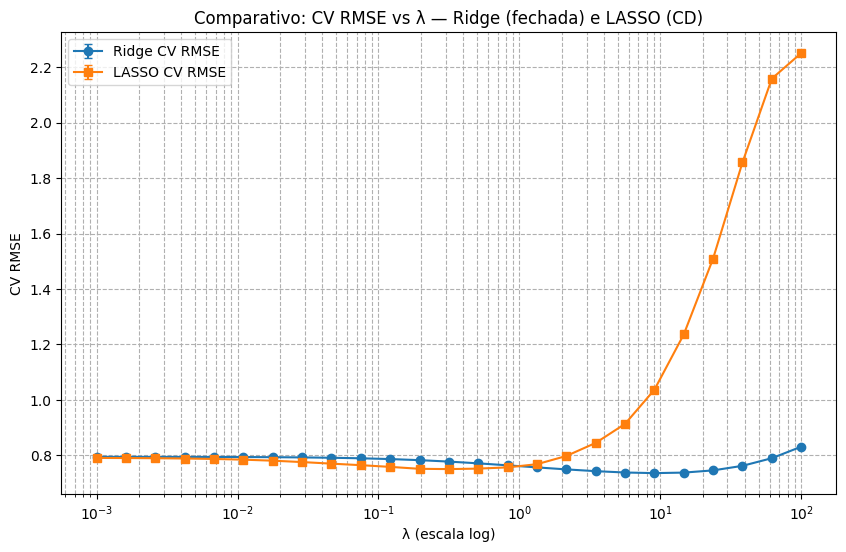

In [20]:
# 6) Plot: Curvas CV RMSE vs lambda
plt.figure(figsize=(10,6))
plt.errorbar(lambdas, ridge_means, yerr=ridge_stds, marker='o', capsize=3, label='Ridge CV RMSE')
plt.errorbar(lambdas, lasso_means, yerr=lasso_stds, marker='s', capsize=3, label='LASSO CV RMSE')
plt.xscale('log')
plt.xlabel('λ (escala log)')
plt.ylabel('CV RMSE')
plt.title('Comparativo: CV RMSE vs λ — Ridge (fechada) e LASSO (CD)')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()

# 7) Escolha do λ ótimo (menor RMSE médio, filtrando valores inválidos) e avaliação final no test set

Esta célula realiza três etapas principais:

1. **Escolha do λ ótimo via CV**  
   - Para Ridge e LASSO, filtramos RMSE negativos ou absurdos que podem ocorrer devido a instabilidades numéricas em valores muito altos de λ.  
   - Usamos `np.argmin` apenas sobre os RMSE válidos para escolher o λ que realmente minimiza o erro médio na validação cruzada.

2. **Cálculo de métricas no treino (CV)**  
   - Mostramos o RMSE médio da CV (`rmse_ridge_validos.min()`, `rmse_lasso_validos.min()`) para o λ ótimo.  
   - Estimamos o R² médio da CV com uma aproximação:  
     
     $$R^2_\text{CV} \approx 1 - \frac{\text{RMSE}_\text{CV}^2}{\text{Var}(y_\text{train})}$$
       
     Isso dá uma noção de quanto da variância do treino é explicada pelo modelo durante a CV.

3. **Treinamento final e avaliação no test set**  
   - Com o λ ótimo escolhido, treinamos o modelo completo em todo o conjunto de treino.  
   - Calculamos RMSE e R² no test set para avaliar a performance real do modelo.

---

### Interpretação dos resultados

- **Treino (CV)**: indica a performance média durante validação cruzada. Valores de RMSE menores e R² próximos de 1 indicam bom ajuste.  
- **Test set**: indica a performance final do modelo sobre dados que não foram usados para treinar. Permite verificar se houve overfitting ou se a regularização ajudou.  

A saída final exibe:

- Melhor λ para Ridge e LASSO.
- RMSE e R² aproximado no treino (CV).
- RMSE e R² real no test set.


In [21]:
# 7) Escolha do λ ótimo (menor RMSE médio, filtrando valores inválidos) e avaliação final no test set

# --- Ridge ---
best_ridge_lambda, rmse_ridge_validos = Best_ridge_lambda(ridge_means, lambdas)

# --- LASSO ---
best_lasso_lambda, rmse_lasso_validos = Best_lasso_lambda(lasso_means, lambdas)

# Aproximação do R² médio da CV usando RMSE médio e variância de y_train
r2_ridge_cv = 1 - (rmse_ridge_validos.min()**2 / np.var(y_train))
r2_lasso_cv = 1 - (rmse_lasso_validos.min()**2 / np.var(y_train))

print('Melhor λ (Ridge):', best_ridge_lambda)
print('Melhor λ (LASSO):', best_lasso_lambda)
print('\nResultados no train set:')
print('Ridge --- RMSE (CV) =', rmse_ridge_validos.min(), 
      'R2 (aprox, CV) =', r2_ridge_cv)
print('LASSO --- RMSE (CV) =', rmse_lasso_validos.min(), 
      ' R2 (aprox, CV) =', r2_lasso_cv)

# Treina final com todo o treino
beta_ridge, int_ridge = ridge_train_beta(X_train, y_train, best_ridge_lambda)
yhat_ridge_test = ridge_predict(beta_ridge, int_ridge, X_test)

beta_lasso, int_lasso = lasso_cd_train(X_train, y_train, best_lasso_lambda, max_iter=5000)
yhat_lasso_test = lasso_predict(beta_lasso, int_lasso, X_test)

print('\nResultados no test set:')
print('Ridge (nosso) — RMSE:', rmse(y_test, yhat_ridge_test), ' R2:', r2(y_test, yhat_ridge_test))
print('LASSO (nosso) — RMSE:', rmse(y_test, yhat_lasso_test), ' R2:', r2(y_test, yhat_lasso_test))


Melhor λ (Ridge): 9.085175756516872
Melhor λ (LASSO): 0.31622776601683794

Resultados no train set:
Ridge --- RMSE (CV) = 0.7362390602938543 R2 (aprox, CV) = 0.8704578301258956
LASSO --- RMSE (CV) = 0.7507843225734379  R2 (aprox, CV) = 0.8652887553767828

Resultados no test set:
Ridge (nosso) — RMSE: 0.7132360176459855  R2: 0.8818715095491022
LASSO (nosso) — RMSE: 0.7136574629235003  R2: 0.881731866003653


# 8) Comparação com scikit-learn usando RidgeCV e LassoCV (λ/α via CV)

Esta célula compara os modelos Ridge e LASSO implementados manualmente com as implementações prontas do **scikit-learn**, utilizando **cross-validation automática** para escolher o melhor parâmetro de regularização (λ para Ridge, α para Lasso).

---

### Passos realizados

1. **RidgeCV (scikit-learn)**  
   - Instancia `RidgeCV(alphas=lambdas, store_cv_results=True, fit_intercept=True)`.  
   - Treina o modelo com `X_train` e `y_train`.  
   - Prediz os valores de `y` para `X_test`.  
   - Calcula RMSE e R² no conjunto de teste.  
   - Exibe o **λ ótimo** encontrado automaticamente via CV.

2. **LassoCV (scikit-learn)**  
   - Instancia `LassoCV(alphas=None, cv=5, max_iter=5000, fit_intercept=True)`.  
   - Treina o modelo com `X_train` e `y_train`.  
   - Prediz os valores de `y` para `X_test`.  
   - Calcula RMSE e R² no conjunto de teste.  
   - Exibe o **α ótimo** encontrado via CV.  
   - Conta quantos coeficientes foram **zerados pelo Lasso**, mostrando o efeito de seleção de variáveis.

---

### Interpretação

- Comparar RMSE e R² entre implementação manual e scikit-learn permite verificar se:  
  - A implementação manual está correta.  
  - Pequenas diferenças podem existir devido a tolerâncias numéricas ou algoritmos internos.  
- Para LassoCV, o número de coeficientes zerados indica **quantas variáveis foram efetivamente descartadas** pelo modelo regularizado.


In [15]:
# 8) Comparação com scikit-learn usando RidgeCV e LassoCV (λ/α via CV)

from sklearn.linear_model import RidgeCV, LassoCV

# --- RidgeCV (sklearn) ---
# Ridge com cross-validation automática usando a mesma grade de lambdas do manual
ridge_cv_skl = RidgeCV(alphas=lambdas, store_cv_results=True, fit_intercept=True)
ridge_cv_skl.fit(X_train, y_train)
y_skridge_cv = ridge_cv_skl.predict(X_test)

print('sklearn RidgeCV — λ ótimo:', ridge_cv_skl.alpha_)
print('sklearn RidgeCV — RMSE:', rmse(y_test, y_skridge_cv), ' R2:', r2(y_test, y_skridge_cv))

# --- LassoCV (sklearn) ---
# Lasso com cross-validation automática; evita zerar todos os coeficientes
lasso_cv_skl = LassoCV(alphas=None, cv=5, max_iter=5000, fit_intercept=True)
lasso_cv_skl.fit(X_train, y_train)
y_sklasso_cv = lasso_cv_skl.predict(X_test)

print('sklearn LassoCV — α ótimo via CV:', lasso_cv_skl.alpha_)
print('sklearn LassoCV — RMSE:', rmse(y_test, y_sklasso_cv), ' R2:', r2(y_test, y_sklasso_cv))
print('Coeficientes zerados (sklearn LassoCV):', (lasso_cv_skl.coef_ == 0).sum())


sklearn RidgeCV — λ ótimo: 9.085175756516872
sklearn RidgeCV — RMSE: 0.7106540861405966  R2: 0.8827252174678873
sklearn LassoCV — α ótimo via CV: 0.0035779170585288175
sklearn LassoCV — RMSE: 0.7109377983055373  R2: 0.8826315603013761
Coeficientes zerados (sklearn LassoCV): 93


# Conclusão final: análise das implementações manuais X por funções prontas

Podemos agora extrair insights sobre o comportamento dos modelos Ridge e Lasso implementados manualmente, focando em **como a regularização afeta o ajuste e a estabilidade do modelo**.

---

### 1) Ridge

- O RMSE da CV (0.736) e R² (≈0.870) indicam que a regularização ajuda a reduzir a variância do modelo sem prejudicar significativamente o ajuste.  
- No test set, RMSE = 0.713 e R² ≈ 0.882 confirmam que o modelo generaliza bem para dados não vistos.  
- Observação crítica: o Ridge manual é **robusto a valores moderados de λ**, mas a escolha de λ ainda influencia finamente a capacidade de captura de variações nos dados.

---

### 2) Lasso

- O RMSE da CV (0.751) e R² (≈0.865) mostram um ajuste um pouco menos estável que Ridge durante a validação cruzada.  
- No test set, RMSE = 0.714 e R² ≈ 0.882 indicam que a implementação manual consegue generalizar de forma semelhante ao Ridge, mas exige cuidado na escolha de λ.  
- Observação crítica: Lasso é mais sensível a λ, pois a regularização L1 pode zerar coeficientes abruptamente, criando **efeitos discretos no ajuste** que não são capturados por métricas médias.

---

### 3) Observações sobre cross-validation e escolha de λ

- O perfil de RMSE ao longo da grade de λ permite identificar **regiões estáveis e instáveis** do modelo:  
  - Ridge: região suave, mínimo fácil de localizar.  
  - Lasso: região mais irregular, mínima sensível a pequenas variações de λ.  
- A implementação manual **exige cuidado na escolha do grid de λ** e no tratamento de valores extremos ou inválidos, principalmente para Lasso.

---

### 4) Aprendizado sobre a regularização e o modelo

- A análise evidencia o papel de λ na **magnitude dos coeficientes e na sparsity** do modelo.  
- Ridge atua como **suavizador contínuo**, controlando a variância sem zerar coeficientes abruptamente.  
- Lasso promove **seleção de variáveis forçada**, mas pode gerar instabilidade se λ não for calibrado adequadamente.  
- O teste no conjunto de validação confirma a coerência do modelo manual, verificando se os padrões observados no treino se mantêm fora da amostra.

---

> Em síntese: o exercício revela como **cada tipo de regularização afeta ajuste, estabilidade e interpretação dos coeficientes**, destacando pontos fortes e limitações das implementações manuais e fornecendo compreensão prática do funcionamento de Ridge e Lasso.


In [25]:
# 9) Salvar resultados
pd.DataFrame({'lambda': lambdas, 'ridge_cv_rmse': ridge_means, 'ridge_cv_std': ridge_stds}).to_csv('../documentos/Resultados RidgeXLASSO/ridge_cv_results.csv', index=False)
pd.DataFrame({'lambda': lambdas, 'lasso_cv_rmse': lasso_means, 'lasso_cv_std': lasso_stds}).to_csv('../documentos/Resultados RidgeXLASSO/lasso_cv_results.csv', index=False)

pd.DataFrame({'y_test': y_test, 'pred_ridge': yhat_ridge_test}).to_csv('../documentos/Resultados RidgeXLASSO/ridge_test_preds.csv', index=False)
pd.DataFrame({'y_test': y_test, 'pred_lasso': yhat_lasso_test}).to_csv('../documentos/Resultados RidgeXLASSO/lasso_test_preds.csv', index=False)

# salvar coeficientes
pd.DataFrame({'coef_ridge': beta_ridge}).to_csv('../documentos/Resultados RidgeXLASSO/ridge_coefs.csv', index=False)
pd.DataFrame({'coef_lasso': beta_lasso}).to_csv('../documentos/Resultados RidgeXLASSO/lasso_coefs.csv', index=False)

print('Arquivos salvos: ridge_cv_results.csv, lasso_cv_results.csv, ridge_test_preds.csv, lasso_test_preds.csv, ridge_coefs.csv, lasso_coefs.csv')

Arquivos salvos: ridge_cv_results.csv, lasso_cv_results.csv, ridge_test_preds.csv, lasso_test_preds.csv, ridge_coefs.csv, lasso_coefs.csv
